<a href="https://colab.research.google.com/github/Angry-Jupiter/kp_3_buff/blob/main/%D0%BA%D1%83%D1%80%D1%81%D0%B0%D1%87_%D0%B1%D0%B8%D1%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np

def simple_ode(t, y):
    x, y_val = y
    dxdt = y_val - x**3
    dydt = -x - y_val**3
    return np.array([dxdt, dydt])

def simple_jacobian(t, y):
    x, y_val = y
    J = np.array([
        [-3*x**2, 1.0],
        [-1.0, -3*y_val**2]
    ])
    return J

def rk4_step(t, y, dt):
    k1 = heart_ode(t, y)
    k2 = heart_ode(t + dt/2, y + dt/2 * k1)
    k3 = heart_ode(t + dt/2, y + dt/2 * k2)
    k4 = heart_ode(t + dt, y + dt * k3)
    y_new = y + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    return y_new


def integrate_simple(y0, T, dt=0.001):
    t = 0.0
    y = y0.copy()
    n_steps = int(T / dt)
    for i in range(n_steps):
        y = rk4_step(t, y, dt)
        t += dt
    return y

def shooting_newton_simple(y0_guess, T=10.0, dt=0.001, max_iter=10, tol=1e-8):
    print("МЕТОД НЬЮТОНА")
    y0 = y0_guess.copy()

    for iter_num in range(max_iter):

        y_T = integrate_simple(y0, T, dt)


        G = y_T - y0
        norm_G = np.linalg.norm(G)


        J = simple_jacobian(0, y0)

        Phi = np.eye(2)
        t = 0.0
        for i in range(int(T / dt)):
            J_at_t = simple_jacobian(t, y0)
            Phi = Phi + dt * (J_at_t @ Phi)
            t += dt

        dG_dy0 = Phi - np.eye(2)

        try:
            delta_y0 = np.linalg.solve(dG_dy0, -G)
        except np.linalg.LinAlgError:
            print("Матрица вырождена")
            break

        norm_delta = np.linalg.norm(delta_y0)

        print(f"{iter_num+1:2d}\t||G||={norm_G:.2e}\t||Δy||={norm_delta:.2e}")

        if norm_G < tol and norm_delta < tol:
            print("Сходимость достигнута!")
            return y0 + delta_y0

        y0 = y0 + delta_y0

    print("Достигнут лимит итераций")
    return y0

In [12]:
# Проверим численно
def num_jacobian(y, h=1e-6):
    J = np.zeros((2,2))
    f0 = simple_ode(0, y)
    for i in range(2):
        y_plus = y.copy()
        y_plus[i] += h
        f_plus = simple_ode(0, y_plus)
        J[:,i] = (f_plus - f0) / h
    return J

y_test = np.array([0.1, 0.2])
J_anal = simple_jacobian(0, y_test)
J_num = num_jacobian(y_test)

print("Аналитическая Якоби:")
print(J_anal)
print("\nЧисленная Якоби:")
print(J_num)
print(f"\nРазница: {np.max(np.abs(J_anal - J_num)):.2e}")

Аналитическая Якоби:
[[-0.03  1.  ]
 [-1.   -0.12]]

Численная Якоби:
[[-0.0300003  1.       ]
 [-1.        -0.1200006]]

Разница: 6.00e-07


In [13]:
import numpy as np
from scipy.optimize import root

T_cycle = 0.8          # период сердечного цикла (с)
T_sys = 0.3            # длительность систолы ЛЖ (с)
E_min = 0.05           # мин. эластичность
E_max_LV = 2.0         # макс. эластичность ЛЖ
E_max_RV = 1.5         # макс. эластичность ПЖ
V0_LV = 10             # нулевой объём ЛЖ (мл)
V0_RV = 10             # нулевой объём ПЖ (мл)
V0_LA = 5              # нулевой объём ЛП (мл)
V0_RA = 5              # нулевой объём ПП (мл)
R_MV = 0.02            # митральный клапан
R_TV = 0.02            # трикуспидальный клапан
R_PV = 0.025           # лёгочный клапан
C_SYS_AR = 1.5         # комплаенс аорты (мл/мм рт.ст.)
C_SYS_VEN = 10.0       # комплаенс вен
C_PUL_AR = 1.2         # комплаенс лёгочной артерии
L_SYS_AR = 0.005       # инерция системного потока
L_SYS_VEN = 0.001      # инерция венозного потока
L_PUL_AR = 0.003       # инерция лёгочного потока
R_SYS_AR = 1.2         # сопротивление системного русла
R_SYS_VEN = 0.1        # сопротивление системных вен
R_PUL_AR = 0.8         # сопротивление лёгочного русла

P_PUL_VEN = 8.0        # давление в лёгочных венах (мм рт.ст.)
P_SYS_VEN = 5.0        # давление в системных венах (мм рт.ст.)


E_LA_const = 0.12
E_RA_const = 0.10

def E_LV(t):
    phase = ((t % T_cycle) - 0.0) / T_sys
    if 0 <= phase <= 1:
        return E_min + (E_max_LV - E_min) * (np.sin(np.pi * phase))**3
    else:
        return E_min

def E_RV(t):
    phase = ((t % T_cycle) - 0.05*T_cycle) / T_sys
    if 0 <= phase <= 1:
        return E_min + (E_max_RV - E_min) * (np.sin(np.pi * phase))**3
    else:
        return E_min

def valve_flow(p_up, p_down, R_forward, R_backward_factor=1e3):
    # Возвращает поток из "up" в "down"
    dp = p_up - p_down
    if dp >= 0.0:
        return dp / R_forward
    else:
        # обратное сопротивление >> прямое
        return dp / (R_forward * R_backward_factor)

def heart_ode(t, y):

    pA, qA, pP, qP, VL_a, VL_v, VR_a, VR_v, qV = y

    VL_a = max(VL_a, V0_LA)
    VR_a = max(VR_a, V0_RA)
    VL_v = VL_v = VL_v if (VL_v := VL_v if 'VL_v' in locals() else None) is not None else VL_v


    p_LV = E_LV(t) * (VL_v - V0_LV)
    p_RV = E_RV(t) * (VR_v - V0_RV)

    p_LA = E_LA_const * (VL_a - V0_LA)
    p_RA = E_RA_const * (VR_a - V0_RA)

    Q_MV = valve_flow(p_LA, p_LV, R_MV)
    Q_AV = valve_flow(p_LV, pA, R_AV)
    Q_TV = valve_flow(p_RA, p_RV, R_TV)
    Q_PV = valve_flow(p_RV, pP, R_PV)

    Q_SYS_AR = qA
    Q_PUL_AR = qP
    Q_SYS_VEN = qV

    dpA_dt = (Q_AV - Q_SYS_AR) / C_SYS_AR
    dqA_dt = (pA - p_RA - R_SYS_AR * Q_SYS_AR) / L_SYS_AR
    dpP_dt = (Q_PV - Q_PUL_AR) / C_PUL_AR
    dqP_dt = (pP - p_LA - R_PUL_AR * Q_PUL_AR) / L_PUL_AR
    dVL_a_dt = Q_PUL_AR - Q_MV
    dVL_v_dt = Q_MV - Q_AV
    dVR_a_dt = Q_SYS_VEN - Q_TV
    dVR_v_dt = Q_TV - Q_PV

    dqV_dt = (P_SYS_VEN - p_RA - R_SYS_VEN * Q_SYS_VEN) / L_SYS_VEN

    return np.array([dpA_dt, dqA_dt, dpP_dt, dqP_dt, dVL_a_dt, dVL_v_dt, dVR_a_dt, dVR_v_dt, dqV_dt], dtype=float)


def rk4_step(t, y, dt):
    k1 = heart_ode(t, y)
    k2 = heart_ode(t + dt/2, y + dt/2 * k1)
    k3 = heart_ode(t + dt/2, y + dt/2 * k2)
    k4 = heart_ode(t + dt, y + dt * k3)
    y_new = y + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    return y_new

def integrate_cycle(y0, dt=0.0002):
    t = 0.0
    y = y0.copy()
    n_steps = int(T_cycle / dt)
    for i in range(n_steps):
        y = rk4_step(t, y, dt)
        t += dt
    return y

# Функция для root: G(y0) = y(T) - y0
def G(y0):
    yT = integrate_cycle(y0, dt=0.0002)
    return yT - y0

R_AV = 0.03

# начч приближ
y0_guess = np.array([
    90.0,   # p_SYS_AR
    150.0,  # q_SYS_AR
    15.0,   # p_PUL_AR
    120.0,  # q_PUL_AR
    40.0,   # V_LA
    90.0,   # V_LV
    50.0,   # V_RA
    70.0,   # V_RV
    100.0   # q_SYS_VEN
])

y0_guess_improved = integrate_cycle(y0_guess, dt=0.0002)

print(f"y0_guess_improved = {y0_guess_improved.round(3)}")

result = root(G, y0_guess_improved, method='hybr')

if result.success:
    y_sol = result.x
    print("\n Решение найдено:")
    names = ['p_SYS_AR', 'q_SYS_AR', 'p_PUL_AR', 'q_PUL_AR',
             'V_LA', 'V_LV', 'V_RA', 'V_RV', 'q_SYS_VEN']
    for name, val in zip(names, y_sol):
        print(f"{name:10s}: {val:8.3f}")
else:
    print("\n Не удалось найти решение")
    print("Код:", result.message)

if result.success:
    y0_guess_improved2 = y_sol
    result2 = root(G, y0_guess_improved2, method='hybr')
    if result2.success:
        y_sol2 = result2.x
        print("\n Уточнённое решение:")
        for name, val in zip(names, y_sol2):
            print(f"{name:10s}: {val:8.3f}")


y0_guess_improved = [70.688 56.593 23.391 23.976 40.751 87.84  34.418 62.171 20.619]

 Решение найдено:
p_SYS_AR  :   27.334
q_SYS_AR  :   20.837
p_PUL_AR  :   17.004
q_PUL_AR  :   18.434
V_LA      :   24.315
V_LV      :   50.127
V_RA      :   28.927
V_RV      :   50.057
q_SYS_VEN :   26.138

 Уточнённое решение:
p_SYS_AR  :   27.334
q_SYS_AR  :   20.837
p_PUL_AR  :   17.004
q_PUL_AR  :   18.434
V_LA      :   24.315
V_LV      :   50.127
V_RA      :   28.927
V_RV      :   50.057
q_SYS_VEN :   26.138


In [14]:
import numpy as np
from numpy.linalg import eig

def compute_J_at_y(t, y, eps=1e-6):
    n = len(y)
    f0 = heart_ode(t, y)
    J = np.zeros((n, n))
    for i in range(n):
        dy = np.zeros(n); dy[i] = eps
        f1 = heart_ode(t, y + dy)
        J[:, i] = (f1 - f0) / eps
    return J

def compute_monodromy(y0, dt=2e-4):
    n = len(y0)
    Phi = np.eye(n)
    y = y0.copy()
    t = 0.0
    n_steps = int(T_cycle / dt)
    for _ in range(n_steps):
        J1 = compute_J_at_y(t, y)
        k1y = heart_ode(t, y)
        k1Phi = J1.dot(Phi)

        y2 = y + dt/2 * k1y
        Phi2 = Phi + dt/2 * k1Phi
        J2 = compute_J_at_y(t + dt/2, y2)
        k2y = heart_ode(t + dt/2, y2)
        k2Phi = J2.dot(Phi2)

        y3 = y + dt/2 * k2y
        Phi3 = Phi + dt/2 * k2Phi
        J3 = compute_J_at_y(t + dt/2, y3)
        k3y = heart_ode(t + dt/2, y3)
        k3Phi = J3.dot(Phi3)

        y4 = y + dt * k3y
        Phi4 = Phi + dt * k3Phi
        J4 = compute_J_at_y(t + dt, y4)
        k4y = heart_ode(t + dt, y4)
        k4Phi = J4.dot(Phi4)

        y = y + dt/6 * (k1y + 2*k2y + 2*k3y + k4y)
        Phi = Phi + dt/6 * (k1Phi + 2*k2Phi + 2*k3Phi + k4Phi)
        t += dt
    return Phi, y

y_fixed = np.array([27.334,20.837,17.004,18.434,24.315,50.127,28.927,50.057,26.138])
Phi, yT = compute_monodromy(y_fixed, dt=2e-4)
eigvals, eigvecs = eig(Phi)
print("Матрица:\n", eigvals)
print("макс:", np.max(np.abs(eigvals)))


Матрица:
 [ 7.78657354e-01+0.00000000e+00j  5.89161189e-01+0.00000000e+00j
  1.85037816e-01+0.00000000e+00j  8.83554397e-02+0.00000000e+00j
  3.92023489e-05+0.00000000e+00j  1.73794165e-05+0.00000000e+00j
  2.33253560e-17+4.79363655e-17j  2.33253560e-17-4.79363655e-17j
 -2.42305639e-19+0.00000000e+00j]
макс: 0.7786573540842451


100%|██████████| 30/30 [02:46<00:00,  5.54s/it]


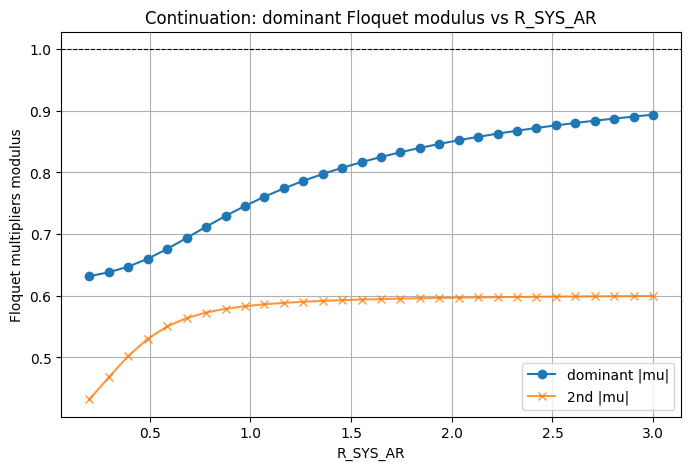

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy.linalg import eig

R_min, R_max, N_R = 0.2, 3.0, 30
R_values = np.linspace(R_min, R_max, N_R)

dt_var = 2e-4

n_relax_cycles = 6

y_cont = np.array([27.334,20.837,17.004,18.434,24.315,50.127,28.927,50.057,26.138], dtype=float)

def compute_J_at_y(t, y, eps=1e-6):
    n = len(y)
    f0 = heart_ode(t, y)
    J = np.zeros((n, n), dtype=float)
    for i in range(n):
        dy = np.zeros(n); dy[i] = eps
        f1 = heart_ode(t, y + dy)
        J[:, i] = (f1 - f0) / eps
    return J

def compute_monodromy(y0, dt=2e-4):
    n = len(y0)
    Phi = np.eye(n)
    y = y0.copy()
    t = 0.0
    n_steps = int(np.round(T_cycle / dt))
    for _ in range(n_steps):
        J1 = compute_J_at_y(t, y)
        k1y = heart_ode(t, y)
        k1Phi = J1.dot(Phi)

        y2 = y + dt/2 * k1y
        Phi2 = Phi + dt/2 * k1Phi
        J2 = compute_J_at_y(t + dt/2, y2)
        k2y = heart_ode(t + dt/2, y2)
        k2Phi = J2.dot(Phi2)

        y3 = y + dt/2 * k2y
        Phi3 = Phi + dt/2 * k2Phi
        J3 = compute_J_at_y(t + dt/2, y3)
        k3y = heart_ode(t + dt/2, y3)
        k3Phi = J3.dot(Phi3)

        y4 = y + dt * k3y
        Phi4 = Phi + dt * k3Phi
        J4 = compute_J_at_y(t + dt, y4)
        k4y = heart_ode(t + dt, y4)
        k4Phi = J4.dot(Phi4)

        y = y + dt/6 * (k1y + 2*k2y + 2*k3y + k4y)
        Phi = Phi + dt/6 * (k1Phi + 2*k2Phi + 2*k3Phi + k4Phi)
        t += dt

    return Phi, y

def dominant_multipliers(Phi, k=3):
    vals, vecs = eig(Phi)
    idx = np.argsort(-np.abs(vals))
    return vals[idx][:k], np.abs(vals)[idx][:k]

dominant_mods = []
second_mods = []
all_vals = []

for R in tqdm(R_values):
    R_SYS_AR = float(R)
    y_try = y_cont.copy()
    for _ in range(n_relax_cycles):
        y_try = integrate_cycle(y_try, dt=dt_var)
    Phi, yT = compute_monodromy(y_try, dt=dt_var)

    vals, mods = dominant_multipliers(Phi, k=5)
    dominant_mods.append(mods[0])
    second_mods.append(mods[1])
    all_vals.append(vals)

    y_cont = yT.copy()

plt.figure(figsize=(8,5))
plt.plot(R_values, dominant_mods, '-o', label='dominant |mu|')
plt.plot(R_values, second_mods, '-x', label='2nd |mu|', alpha=0.8)
plt.axhline(1.0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('R_SYS_AR')
plt.ylabel('Floquet multipliers modulus')
plt.title('Continuation: dominant Floquet modulus vs R_SYS_AR')
plt.legend()
plt.grid(True)
plt.show()

for R, m in zip(R_values, dominant_mods):
    if m > 0.9:
        print(f'WARN: R={R:.3f}, dominant |mu|={m:.5f}')



In [16]:
import numpy as np
from numpy.linalg import eig
from tqdm import tqdm

R_scan_min, R_scan_max = 3.0, 9.0
N_scan = 30
dt_var = 2e-4
n_relax_cycles = 6
eps_J = 1e-6
mu_threshold = 1.0
bisect_tol_R = 1e-3
bisect_tol_mu = 1e-3

y_cont = np.array([27.334,20.837,17.004,18.434,24.315,50.127,28.927,50.057,26.138], dtype=float)

def compute_J_at_y(t, y, eps=eps_J):
    n = len(y)
    f0 = heart_ode(t, y)
    J = np.zeros((n, n), dtype=float)
    for i in range(n):
        dy = np.zeros(n); dy[i] = eps
        f1 = heart_ode(t, y + dy)
        J[:, i] = (f1 - f0) / eps
    return J

def compute_monodromy(y0, dt=dt_var):
    n = len(y0)
    Phi = np.eye(n)
    y = y0.copy()
    t = 0.0
    n_steps = int(np.round(T_cycle / dt))
    for _ in range(n_steps):
        J1 = compute_J_at_y(t, y)
        k1y = heart_ode(t, y)
        k1Phi = J1.dot(Phi)

        y2 = y + dt/2 * k1y
        Phi2 = Phi + dt/2 * k1Phi
        J2 = compute_J_at_y(t + dt/2, y2)
        k2y = heart_ode(t + dt/2, y2)
        k2Phi = J2.dot(Phi2)

        y3 = y + dt/2 * k2y
        Phi3 = Phi + dt/2 * k2Phi
        J3 = compute_J_at_y(t + dt/2, y3)
        k3y = heart_ode(t + dt/2, y3)
        k3Phi = J3.dot(Phi3)

        y4 = y + dt * k3y
        Phi4 = Phi + dt * k3Phi
        J4 = compute_J_at_y(t + dt, y4)
        k4y = heart_ode(t + dt, y4)
        k4Phi = J4.dot(Phi4)

        y = y + dt/6 * (k1y + 2*k2y + 2*k3y + k4y)
        Phi = Phi + dt/6 * (k1Phi + 2*k2Phi + 2*k3Phi + k4Phi)
        t += dt

    return Phi, y

def dominant_modulus(Phi):
    vals = eig(Phi)[0]
    return np.max(np.abs(vals)), vals

R_values = np.linspace(R_scan_min, R_scan_max, N_scan)
dominant_list = []
R_found_interval = None
y_when_found = None

print("Starting coarse scan...")
for R in tqdm(R_values):

    globals()['R_SYS_AR'] = float(R)

    y_try = y_cont.copy()
    for _ in range(n_relax_cycles):
        y_try = integrate_cycle(y_try, dt=dt_var)

    Phi, yT = compute_monodromy(y_try, dt=dt_var)
    dom_mod, vals = dominant_modulus(Phi)
    dominant_list.append((R, float(dom_mod)))

    y_cont = yT.copy()

    if dom_mod >= mu_threshold:
        R_found_interval = R
        y_when_found = (y_try.copy(), vals.copy())
        break

if R_found_interval is None:
    print("Coarse scan did not find crossing |mu|>=1 in the interval.")

    max_info = max(dominant_list, key=lambda x: x[1])
    print(f"Max dominant modulus found = {max_info[1]:.5f} at R = {max_info[0]:.5f}")
else:
    print(f"Found coarse crossing at R ≈ {R_found_interval:.5f}")

if R_found_interval is not None:
    idx_found = next(i for i,(Rval,m) in enumerate(dominant_list) if Rval==R_found_interval)
    if idx_found == 0:
        R_L = R_values[0]
    else:
        R_L = dominant_list[idx_found-1][0]
    R_U = R_found_interval

    print(f"Refining in interval [{R_L:.6f}, {R_U:.6f}]")

    max_bisect_iter = 30
    iter_count = 0
    R_low, R_high = R_L, R_U
    y_seed = None

    while (R_high - R_low) > bisect_tol_R and iter_count < max_bisect_iter:
        R_mid = 0.5*(R_low + R_high)
        globals()['R_SYS_AR'] = float(R_mid)

        if y_seed is None:
            y_try = y_when_found[0].copy()
        else:
            y_try = y_seed.copy()

        # relax
        for _ in range(n_relax_cycles):
            y_try = integrate_cycle(y_try, dt=dt_var)

        Phi, yT = compute_monodromy(y_try, dt=dt_var)
        dom_mod, vals = dominant_modulus(Phi)

        print(f"bisect iter {iter_count}: R_mid={R_mid:.6f}, dom_mod={dom_mod:.6f}")

        if dom_mod >= mu_threshold:
            R_high = R_mid
        else:
            R_low = R_mid
            y_seed = yT.copy()

        iter_count += 1

        if abs(dom_mod - 1.0) < bisect_tol_mu:
            print("Converged in mu tolerance.")
            break

    R_crit = 0.5*(R_low + R_high)
    print(f"\nEstimated critical R*: {R_crit:.6f}")
    globals()['R_SYS_AR'] = float(R_crit)
    y_final = y_seed.copy() if y_seed is not None else y_when_found[0].copy()
    for _ in range(n_relax_cycles):
        y_final = integrate_cycle(y_final, dt=dt_var)
    Phi_final, yT_final = compute_monodromy(y_final, dt=dt_var)
    dom_mod_final, vals_final = dominant_modulus(Phi_final)
    print(f"Final dominant modulus at R* = {dom_mod_final:.8f}")
    print("Floquet multipliers at R* :")
    print(vals_final)


Starting coarse scan...


100%|██████████| 30/30 [02:45<00:00,  5.51s/it]

Coarse scan did not find crossing |mu|>=1 in the interval.
Max dominant modulus found = 0.96071 at R = 9.00000


100%|██████████| 40/40 [03:40<00:00,  5.50s/it]


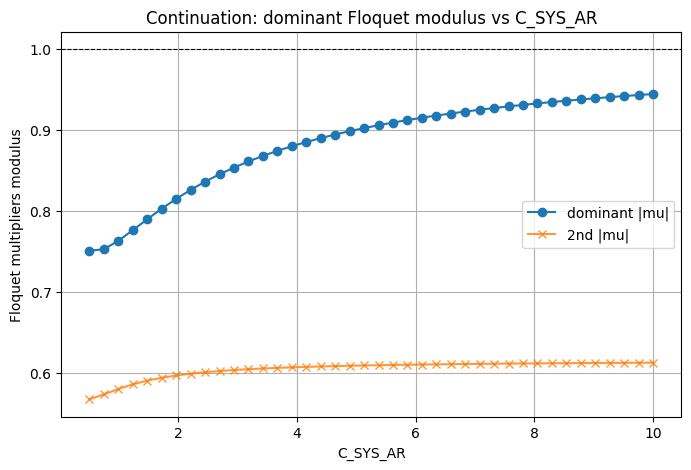

WARN: C_SYS_AR=5.128, dominant |mu|=0.90254
WARN: C_SYS_AR=5.372, dominant |mu|=0.90608
WARN: C_SYS_AR=5.615, dominant |mu|=0.90938
WARN: C_SYS_AR=5.859, dominant |mu|=0.91246
WARN: C_SYS_AR=6.103, dominant |mu|=0.91534
WARN: C_SYS_AR=6.346, dominant |mu|=0.91804
WARN: C_SYS_AR=6.590, dominant |mu|=0.92057
WARN: C_SYS_AR=6.833, dominant |mu|=0.92296
WARN: C_SYS_AR=7.077, dominant |mu|=0.92520
WARN: C_SYS_AR=7.321, dominant |mu|=0.92733
WARN: C_SYS_AR=7.564, dominant |mu|=0.92933
WARN: C_SYS_AR=7.808, dominant |mu|=0.93123
WARN: C_SYS_AR=8.051, dominant |mu|=0.93304
WARN: C_SYS_AR=8.295, dominant |mu|=0.93475
WARN: C_SYS_AR=8.538, dominant |mu|=0.93637
WARN: C_SYS_AR=8.782, dominant |mu|=0.93792
WARN: C_SYS_AR=9.026, dominant |mu|=0.93939
WARN: C_SYS_AR=9.269, dominant |mu|=0.94080
WARN: C_SYS_AR=9.513, dominant |mu|=0.94214
WARN: C_SYS_AR=9.756, dominant |mu|=0.94343
WARN: C_SYS_AR=10.000, dominant |mu|=0.94466


In [20]:
C_min, C_max, N_C = 0.5, 10.0, 40
C_values = np.linspace(C_min, C_max, N_C)

dominant_mods = []
second_mods = []
all_vals = []
y_cont = np.array([27.334,20.837,17.004,18.434,24.315,50.127,28.927,50.057,26.138], dtype=float)

for C in tqdm(C_values):
    C_SYS_AR = float(C)
    y_try = y_cont.copy()
    for _ in range(n_relax_cycles):
        y_try = integrate_cycle(y_try, dt=dt_var)
    Phi, yT = compute_monodromy(y_try, dt=dt_var)

    vals, mods = dominant_multipliers(Phi, k=5)
    dominant_mods.append(mods[0])
    second_mods.append(mods[1])
    all_vals.append(vals)

    y_cont = yT.copy()

plt.figure(figsize=(8,5))
plt.plot(C_values, dominant_mods, '-o', label='dominant |mu|')
plt.plot(C_values, second_mods, '-x', label='2nd |mu|', alpha=0.8)
plt.axhline(1.0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('C_SYS_AR')
plt.ylabel('Floquet multipliers modulus')
plt.title('Continuation: dominant Floquet modulus vs C_SYS_AR')
plt.legend()
plt.grid(True)
plt.show()

for C, m in zip(C_values, dominant_mods):
    if m > 0.9:
        print(f'WARN: C_SYS_AR={C:.3f}, dominant |mu|={m:.5f}')


100%|██████████| 40/40 [03:41<00:00,  5.54s/it]


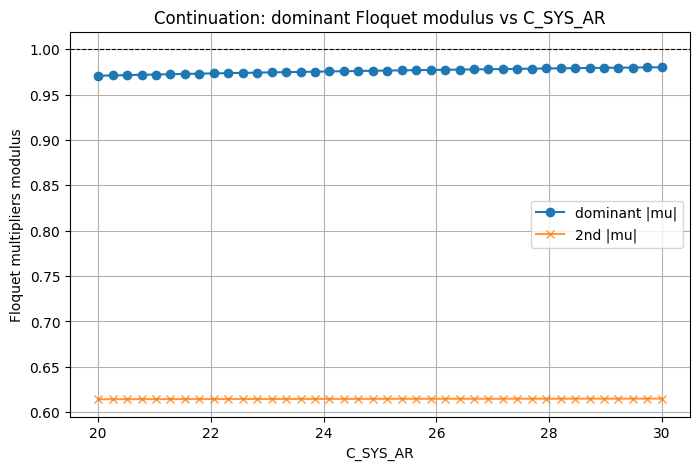

WARN: C_SYS_AR=20.000, dominant |mu|=0.97079
WARN: C_SYS_AR=20.256, dominant |mu|=0.97114
WARN: C_SYS_AR=20.513, dominant |mu|=0.97148
WARN: C_SYS_AR=20.769, dominant |mu|=0.97181
WARN: C_SYS_AR=21.026, dominant |mu|=0.97214
WARN: C_SYS_AR=21.282, dominant |mu|=0.97245
WARN: C_SYS_AR=21.538, dominant |mu|=0.97277
WARN: C_SYS_AR=21.795, dominant |mu|=0.97307
WARN: C_SYS_AR=22.051, dominant |mu|=0.97337
WARN: C_SYS_AR=22.308, dominant |mu|=0.97366
WARN: C_SYS_AR=22.564, dominant |mu|=0.97394
WARN: C_SYS_AR=22.821, dominant |mu|=0.97422
WARN: C_SYS_AR=23.077, dominant |mu|=0.97449
WARN: C_SYS_AR=23.333, dominant |mu|=0.97476
WARN: C_SYS_AR=23.590, dominant |mu|=0.97502
WARN: C_SYS_AR=23.846, dominant |mu|=0.97528
WARN: C_SYS_AR=24.103, dominant |mu|=0.97553
WARN: C_SYS_AR=24.359, dominant |mu|=0.97578
WARN: C_SYS_AR=24.615, dominant |mu|=0.97602
WARN: C_SYS_AR=24.872, dominant |mu|=0.97625
WARN: C_SYS_AR=25.128, dominant |mu|=0.97649
WARN: C_SYS_AR=25.385, dominant |mu|=0.97671
WARN: C_SY

In [22]:
C_min, C_max, N_C = 20.0, 30.0, 40
C_values = np.linspace(C_min, C_max, N_C)

dominant_mods = []
second_mods = []
all_vals = []
y_cont = np.array([27.334,20.837,17.004,18.434,24.315,50.127,28.927,50.057,26.138], dtype=float)

for C in tqdm(C_values):
    C_SYS_AR = float(C)   # 👈 меняем глобальный параметр
    y_try = y_cont.copy()
    for _ in range(n_relax_cycles):
        y_try = integrate_cycle(y_try, dt=dt_var)
    Phi, yT = compute_monodromy(y_try, dt=dt_var)

    vals, mods = dominant_multipliers(Phi, k=5)
    dominant_mods.append(mods[0])
    second_mods.append(mods[1])
    all_vals.append(vals)

    y_cont = yT.copy()

plt.figure(figsize=(8,5))
plt.plot(C_values, dominant_mods, '-o', label='dominant |mu|')
plt.plot(C_values, second_mods, '-x', label='2nd |mu|', alpha=0.8)
plt.axhline(1.0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('C_SYS_AR')
plt.ylabel('Floquet multipliers modulus')
plt.title('Continuation: dominant Floquet modulus vs C_SYS_AR')
plt.legend()
plt.grid(True)
plt.show()

for C, m in zip(C_values, dominant_mods):
    if m > 0.9:
        print(f'WARN: C_SYS_AR={C:.3f}, dominant |mu|={m:.5f}')


100%|██████████| 40/40 [03:40<00:00,  5.52s/it]


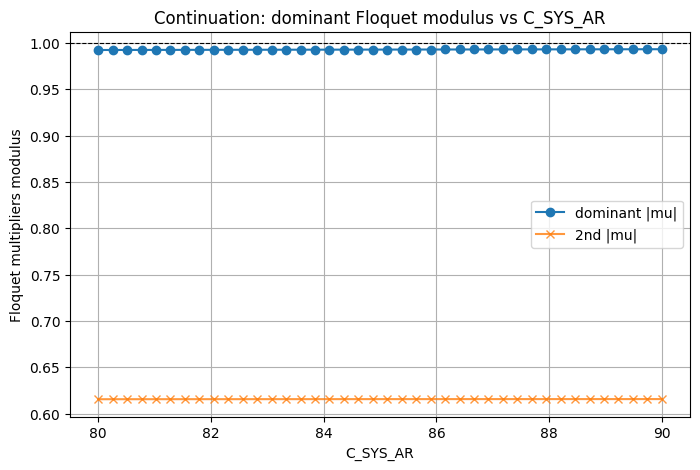

WARN: C_SYS_AR=80.000, dominant |mu|=0.99239
WARN: C_SYS_AR=80.256, dominant |mu|=0.99241
WARN: C_SYS_AR=80.513, dominant |mu|=0.99244
WARN: C_SYS_AR=80.769, dominant |mu|=0.99246
WARN: C_SYS_AR=81.026, dominant |mu|=0.99248
WARN: C_SYS_AR=81.282, dominant |mu|=0.99251
WARN: C_SYS_AR=81.538, dominant |mu|=0.99253
WARN: C_SYS_AR=81.795, dominant |mu|=0.99255
WARN: C_SYS_AR=82.051, dominant |mu|=0.99258
WARN: C_SYS_AR=82.308, dominant |mu|=0.99260
WARN: C_SYS_AR=82.564, dominant |mu|=0.99262
WARN: C_SYS_AR=82.821, dominant |mu|=0.99265
WARN: C_SYS_AR=83.077, dominant |mu|=0.99267
WARN: C_SYS_AR=83.333, dominant |mu|=0.99269
WARN: C_SYS_AR=83.590, dominant |mu|=0.99271
WARN: C_SYS_AR=83.846, dominant |mu|=0.99273
WARN: C_SYS_AR=84.103, dominant |mu|=0.99276
WARN: C_SYS_AR=84.359, dominant |mu|=0.99278
WARN: C_SYS_AR=84.615, dominant |mu|=0.99280
WARN: C_SYS_AR=84.872, dominant |mu|=0.99282
WARN: C_SYS_AR=85.128, dominant |mu|=0.99284
WARN: C_SYS_AR=85.385, dominant |mu|=0.99286
WARN: C_SY

In [23]:
C_min, C_max, N_C = 80.0, 90.0, 40
C_values = np.linspace(C_min, C_max, N_C)

dominant_mods = []
second_mods = []
all_vals = []
y_cont = np.array([27.334,20.837,17.004,18.434,24.315,50.127,28.927,50.057,26.138], dtype=float)

for C in tqdm(C_values):
    C_SYS_AR = float(C)
    y_try = y_cont.copy()
    for _ in range(n_relax_cycles):
        y_try = integrate_cycle(y_try, dt=dt_var)
    Phi, yT = compute_monodromy(y_try, dt=dt_var)

    vals, mods = dominant_multipliers(Phi, k=5)
    dominant_mods.append(mods[0])
    second_mods.append(mods[1])
    all_vals.append(vals)

    y_cont = yT.copy()

plt.figure(figsize=(8,5))
plt.plot(C_values, dominant_mods, '-o', label='dominant |mu|')
plt.plot(C_values, second_mods, '-x', label='2nd |mu|', alpha=0.8)
plt.axhline(1.0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('C_SYS_AR')
plt.ylabel('Floquet multipliers modulus')
plt.title('Continuation: dominant Floquet modulus vs C_SYS_AR')
plt.legend()
plt.grid(True)
plt.show()

for C, m in zip(C_values, dominant_mods):
    if m > 0.9:
        print(f'WARN: C_SYS_AR={C:.3f}, dominant |mu|={m:.5f}')


100%|██████████| 40/40 [03:41<00:00,  5.53s/it]


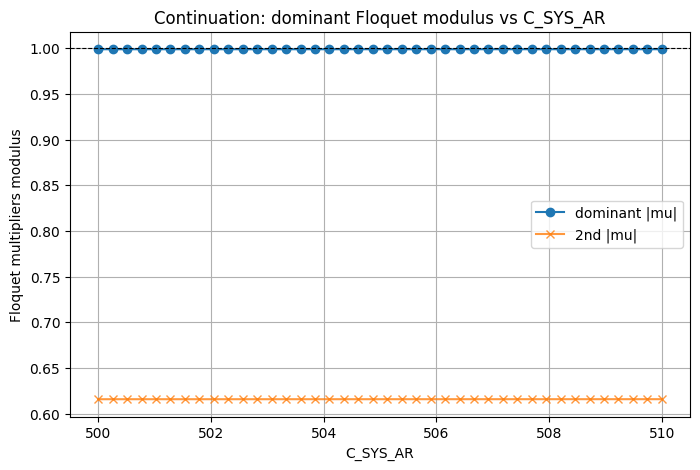

WARN: C_SYS_AR=500.000, dominant |mu|=0.99877
WARN: C_SYS_AR=500.256, dominant |mu|=0.99877
WARN: C_SYS_AR=500.513, dominant |mu|=0.99877
WARN: C_SYS_AR=500.769, dominant |mu|=0.99877
WARN: C_SYS_AR=501.026, dominant |mu|=0.99877
WARN: C_SYS_AR=501.282, dominant |mu|=0.99877
WARN: C_SYS_AR=501.538, dominant |mu|=0.99877
WARN: C_SYS_AR=501.795, dominant |mu|=0.99877
WARN: C_SYS_AR=502.051, dominant |mu|=0.99877
WARN: C_SYS_AR=502.308, dominant |mu|=0.99877
WARN: C_SYS_AR=502.564, dominant |mu|=0.99877
WARN: C_SYS_AR=502.821, dominant |mu|=0.99878
WARN: C_SYS_AR=503.077, dominant |mu|=0.99878
WARN: C_SYS_AR=503.333, dominant |mu|=0.99878
WARN: C_SYS_AR=503.590, dominant |mu|=0.99878
WARN: C_SYS_AR=503.846, dominant |mu|=0.99878
WARN: C_SYS_AR=504.103, dominant |mu|=0.99878
WARN: C_SYS_AR=504.359, dominant |mu|=0.99878
WARN: C_SYS_AR=504.615, dominant |mu|=0.99878
WARN: C_SYS_AR=504.872, dominant |mu|=0.99878
WARN: C_SYS_AR=505.128, dominant |mu|=0.99878
WARN: C_SYS_AR=505.385, dominant |

In [25]:
C_min, C_max, N_C = 1000.0, 510.0, 40
C_values = np.linspace(C_min, C_max, N_C)

dominant_mods = []
second_mods = []
all_vals = []
y_cont = np.array([27.334,20.837,17.004,18.434,24.315,50.127,28.927,50.057,26.138], dtype=float)

for C in tqdm(C_values):
    C_SYS_AR = float(C)
    y_try = y_cont.copy()
    for _ in range(n_relax_cycles):
        y_try = integrate_cycle(y_try, dt=dt_var)
    Phi, yT = compute_monodromy(y_try, dt=dt_var)

    vals, mods = dominant_multipliers(Phi, k=5)
    dominant_mods.append(mods[0])
    second_mods.append(mods[1])
    all_vals.append(vals)

    y_cont = yT.copy()

plt.figure(figsize=(8,5))
plt.plot(C_values, dominant_mods, '-o', label='dominant |mu|')
plt.plot(C_values, second_mods, '-x', label='2nd |mu|', alpha=0.8)
plt.axhline(1.0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('C_SYS_AR')
plt.ylabel('Floquet multipliers modulus')
plt.title('Continuation: dominant Floquet modulus vs C_SYS_AR')
plt.legend()
plt.grid(True)
plt.show()

for C, m in zip(C_values, dominant_mods):
    if m > 0.9:
        print(f'WARN: C_SYS_AR={C:.3f}, dominant |mu|={m:.5f}')


100%|██████████| 30/30 [02:52<00:00,  5.75s/it]


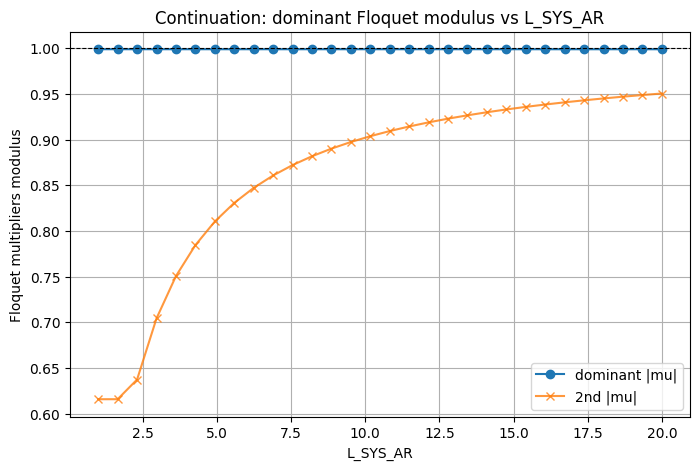

In [29]:
L_min, L_max, N_L = 1.00, 20.0, 30
L_values = np.linspace(L_min, L_max, N_L)

dominant_mods_L = []
second_mods_L = []
all_vals_L = []

y_cont = np.array([27.334,20.837,17.004,18.434,24.315,50.127,28.927,50.057,26.138], dtype=float)

for L in tqdm(L_values):
    L_SYS_AR = float(L)
    y_try = y_cont.copy()
    for _ in range(n_relax_cycles):
        y_try = integrate_cycle(y_try, dt=dt_var)
    Phi, yT = compute_monodromy(y_try, dt=dt_var)

    vals, mods = dominant_multipliers(Phi, k=5)
    dominant_mods_L.append(mods[0])
    second_mods_L.append(mods[1])
    all_vals_L.append(vals)

    y_cont = yT.copy()

plt.figure(figsize=(8,5))
plt.plot(L_values, dominant_mods_L, '-o', label='dominant |mu|')
plt.plot(L_values, second_mods_L, '-x', label='2nd |mu|', alpha=0.8)
plt.axhline(1.0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('L_SYS_AR')
plt.ylabel('Floquet multipliers modulus')
plt.title('Continuation: dominant Floquet modulus vs L_SYS_AR')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
for L, m in zip(L_values, dominant_mods_L):
    if m > 0.9:
        print(f'WARN: C_SYS_AR={C:.3f}, dominant |mu|={m:.5f}')

WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |mu|=0.99879
WARN: C_SYS_AR=510.000, dominant |

100%|██████████| 30/30 [02:45<00:00,  5.53s/it]


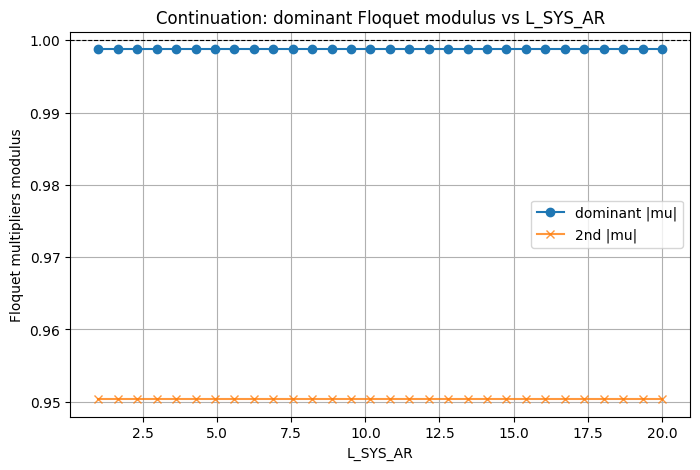

WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |

In [30]:
P_min, P_max, N_P = 8.00, 50.0, 30
P_values = np.linspace(L_min, L_max, N_L)

dominant_mods_P = []
second_mods_P = []
all_vals_P = []

p_cont = np.array([27.334,20.837,17.004,18.434,24.315,50.127,28.927,50.057,26.138], dtype=float)

for P in tqdm(L_values):
    P_PUL_VEN = float(P)
    p_try = p_cont.copy()
    for _ in range(n_relax_cycles):
        p_try = integrate_cycle(p_try, dt=dt_var)
    Phi, pT = compute_monodromy(p_try, dt=dt_var)

    vals, mods = dominant_multipliers(Phi, k=5)
    dominant_mods_P.append(mods[0])
    second_mods_P.append(mods[1])
    all_vals_P.append(vals)

    p_cont = pT.copy()

plt.figure(figsize=(8,5))
plt.plot(P_values, dominant_mods_P, '-o', label='dominant |mu|')
plt.plot(P_values, second_mods_P, '-x', label='2nd |mu|', alpha=0.8)
plt.axhline(1.0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('L_SYS_AR')
plt.ylabel('Floquet multipliers modulus')
plt.title('Continuation: dominant Floquet modulus vs L_SYS_AR')
plt.legend()
plt.grid(True)
plt.show()

for L, m in zip(P_values, dominant_mods_P):
    if m > 0.9:
        print(f'WARN: C_SYS_AR={C:.3f}, dominant |mu|={m:.5f}')

100%|██████████| 30/30 [02:45<00:00,  5.52s/it]


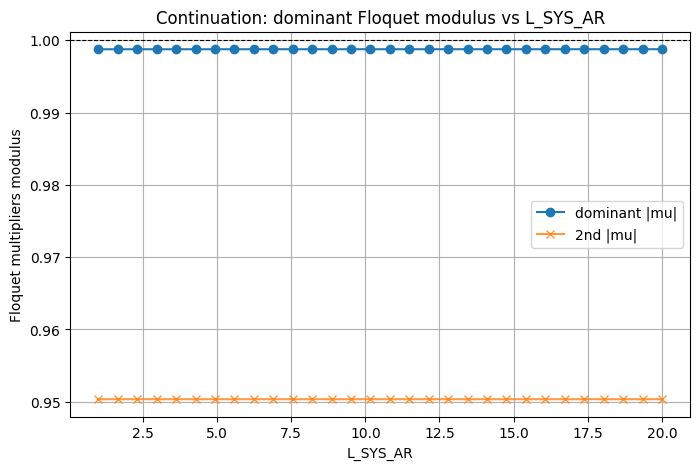

WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99876
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |mu|=0.99877
WARN: C_SYS_AR=510.000, dominant |

In [31]:
P_min, P_max, N_P = 0.00, 50.0, 30
P_values = np.linspace(L_min, L_max, N_L)

dominant_mods_P = []
second_mods_P = []
all_vals_P = []

p_cont = np.array([27.334,20.837,17.004,18.434,24.315,50.127,28.927,50.057,26.138], dtype=float)

for P in tqdm(L_values):
    R_PUL_AR = float(P)
    p_try = p_cont.copy()
    for _ in range(n_relax_cycles):
        p_try = integrate_cycle(p_try, dt=dt_var)
    Phi, pT = compute_monodromy(p_try, dt=dt_var)

    vals, mods = dominant_multipliers(Phi, k=5)
    dominant_mods_P.append(mods[0])
    second_mods_P.append(mods[1])
    all_vals_P.append(vals)

    p_cont = pT.copy()

plt.figure(figsize=(8,5))
plt.plot(P_values, dominant_mods_P, '-o', label='dominant |mu|')
plt.plot(P_values, second_mods_P, '-x', label='2nd |mu|', alpha=0.8)
plt.axhline(1.0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('L_SYS_AR')
plt.ylabel('Floquet multipliers modulus')
plt.title('Continuation: dominant Floquet modulus vs L_SYS_AR')
plt.legend()
plt.grid(True)
plt.show()

for L, m in zip(P_values, dominant_mods_P):
    if m > 0.9:
        print(f'WARN: C_SYS_AR={C:.3f}, dominant |mu|={m:.5f}')